In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wave
obj = wave.open('SDRSharp_20210520_033439Z_1089960000Hz_IQ.wav','r')
print( "Number of channels",obj.getnchannels())
print ( "Sample width",obj.getsampwidth())
print ( "Frame rate.",obj.getframerate())
print ("Number of frames",obj.getnframes())
print ( "parameters:",obj.getparams())
x = obj.readframes(10)
obj.close()

In [ ]:
print(x)

In [ ]:
len(x)

### scipy.io.wavfile.read(somefile) returns a tuple of two items: the first is the sampling rate in samples per second, the second is a numpy array with all the data read from the file:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.io import wavfile
from scipy.interpolate import interp1d
#samplerate, data = wavfile.read('ADS-B_SDRSharp_20150526_203031Z_1090000kHz_IQ.wav')
samplerate, data = wavfile.read('SDRSharp_20210520_033439Z_1089960000Hz_IQ.wav')

In [ ]:
print(samplerate)
print(data)

In [ ]:
print(data.ndim)
print(data.shape)
[M, dummy] = data.shape

In [ ]:
#print(data[62809999:62810330,0]/2048)
print(np.max(data[42809999:42810330,0]))

In [ ]:
z = np.zeros(M, dtype=float)
print(z.shape)
print(data[1,0]/2048.) 
z = np.power(data[0:M,0]/2048.,2)+np.power(data[0:M,1]/2048.,2) # Much faster than the below !
#for i in range(N):
#    z[i]=np.power(data[i][0],2)+np.power(data[i][1],2)

In [ ]:
#t0 = np.arange(0,1/Fs*M,1/Fs)
#print(len(t0))
#plt.plot(t0,z)

In [ ]:
fs = samplerate
start = int(1.7231*fs)
end = int(1.72324*fs)
N = end - start
print(N)
print(z[start:end].shape)
plt.plot(z[start:end])

In [ ]:
x = np.arange(N)
print(x.shape)
print(x[447])
f = interp1d(x, z[start:end], kind='cubic')

In [ ]:
xnew = np.arange(0,N-1,1/25)
print(xnew.shape)   #  447 * 25 = 11175
print(xnew[11174])

In [ ]:
plt.plot(xnew, f(xnew))

In [ ]:
xdeci = xnew[16:11135:20]    # 11135 = 11175 - 40
print(xdeci.shape)
adsb_arr = np.zeros(556, dtype=int)
plt.plot(xdeci, f(xdeci))

In [ ]:
TH = 5.0  # threshold
cnt = 0
for i in xdeci:
    if f(i) >= TH:
        adsb_arr[cnt] = 1
    else:
        adsb_arr[cnt] = 0
    cnt += 1
print(adsb_arr.shape)  
plt.plot(adsb_arr[0:150])


In [ ]:
plt.stem(adsb_arr[0:150:2], markerfmt='m.', use_line_collection = True)

In [ ]:
a = np.arange(10)
print(a[0:10:2])

### Making 3.2MHz samples to 32 MHz (interpolation) and then to 4 MHz (decimation)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.io import wavfile
from scipy.interpolate import interp1d
samplerate, data = wavfile.read('SDRSharp_20210520_033439Z_1089960000Hz_IQ.wav')

In [ ]:
[M, dummy] = data.shape
print(data.shape)
print(data[1900:2100,0]) 

In [ ]:
z = np.zeros(M, dtype=float)
print(z.shape)
print(data[1,0]/2048.) 

In [ ]:
z = np.power(data[0:M,0]/8192.,2)+np.power(data[0:M,1]/8192.,2) # Much faster than the below !
#plt.plot(np.abs(data)/8192.)

In [ ]:
#plt.plot(z)

In [ ]:
z = z[4000000:8000001]

In [ ]:
plt.plot(z)

In [ ]:
z.shape

In [ ]:
x = np.arange(4000001)
print(x.shape)
f = interp1d(x, z, kind='cubic')

#### Interpolation of 10

In [ ]:
xnew = np.arange(0,4000000,1/10)
print(xnew.shape)   #  4000000 * 10

In [ ]:
plt.plot(xnew, f(xnew))

#### Decimation of 8, so fs becomes 4 MHz (= 4M sps)

In [ ]:
xdeci = xnew[1:40000000:8]   # fs = 4MHz
print(xdeci.shape)
#adsb_arr = np.zeros(556, dtype=int)
plt.plot(xdeci, f(xdeci))

In [ ]:
N = xdeci.shape[0]
print(N)
zdeci = np.zeros(N)
zdeci = f(xdeci)
#plt.plot(zdeci)
preamble = np.array([1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0])
corr_arr = np.zeros(N-16)
corr_sgn = np.zeros(N-16)

In [ ]:
for i in range(N-16):
    corr_arr[i] = np.dot(zdeci[i+0:i+16], preamble)

In [ ]:
corr_arr.shape

In [ ]:
plt.plot(corr_arr)

In [ ]:
for i in range(N-16):
    if corr_arr[i] >1.2:
        corr_sgn[i] = corr_arr[i]
    else:
        corr_sgn[i] = 0.
plt.plot(corr_sgn)                 

In [ ]:
idx_max = np.argmax(corr_sgn)
print(idx_max)

In [ ]:
plt.plot(zdeci[idx_max-200:idx_max+200])

In [ ]:
plt.stem(zdeci[idx_max-200:idx_max+200], markerfmt='m.', use_line_collection = True)

In [ ]:
plt.stem(zdeci[idx_max-201:idx_max+200:2], markerfmt='m.', use_line_collection = True)

In [ ]:
zdecision = np.zeros(201)
zdecision[zdeci[idx_max-201:idx_max+200:2] > 0.4] = 1 
plt.plot(zdecision)

In [ ]:
zdecision.shape

In [ ]:
zdecision[31:165]

In [ ]:
plt.stem(zdecision[31:165], markerfmt='m.', use_line_collection = True)

In [ ]:
ord_max = int(15)
idx = np.argpartition(corr_sgn, -ord_max)[-ord_max:]
indices = idx[np.argsort((-corr_sgn)[idx])]
print(indices)

In [ ]:
i = indices[3]
plt.plot(zdeci[i-500:i+500])

## Preamble (1010000101000000) and DF 17 becomes a new preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.io import wavfile
from scipy.interpolate import interp1d
#samplerate, data = wavfile.read('SDRSharp_20210520_033439Z_1089960000Hz_IQ.wav')
samplerate, data = wavfile.read('\Downloads\sdrsharp_adsb\SDRSharp_20210523_090518Z_1089960000Hz_IQ.wav')

In [2]:
[M, dummy] = data.shape
z = np.zeros(M, dtype=float)
print(z.shape)
z = np.power(data[0:M,0]/8192.,2)+np.power(data[0:M,1]/8192.,2) 
z = z[4000000:28000001]   # z = z[4000000:8000001]
print(z.shape)
M_z = np.size(z,0)

(49700864,)
(24000001,)


In [3]:
x = np.arange(M_z)
print(x.shape)
f = interp1d(x, z, kind='cubic')

(24000001,)


In [4]:
xnew = np.arange(0,M_z-1,1/10)
print(xnew.shape)   #  4000000 * 10


(240000000,)


In [5]:
xdeci = xnew[5:(M_z-1)*10:16]   # fs = 2MHz
print(xdeci.shape)

(15000000,)


In [6]:
(M_z-1)*10/16

15000000.0

In [7]:
N = xdeci.shape[0]
print(N)
zdeci = np.zeros(N)
zdeci = f(xdeci)
#plt.plot(zdeci)
preamble = np.array([1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0])
A = preamble.shape[0]
corr_arr = np.zeros(N-A)
corr_sgn = np.zeros(N-A)
print(A)
print(corr_arr.shape)

15000000
26
(14999974,)


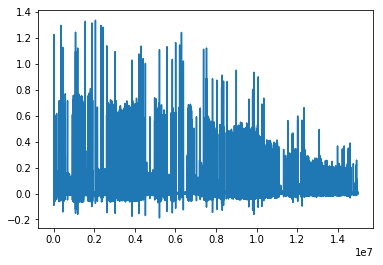

In [8]:
plt.plot(zdeci)

In [9]:
for i in range(N-A):
    corr_arr[i] = np.dot(zdeci[i+0:i+A], preamble)

In [10]:
corr_arr.shape

(14999974,)

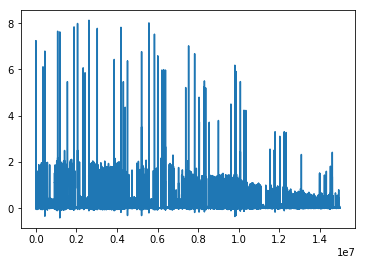

In [11]:
plt.plot(corr_arr)

14999974

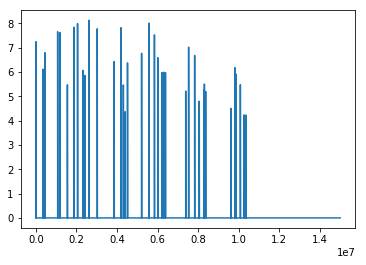

In [12]:
for i in range(N-A):
    if corr_arr[i] > 4:
        corr_sgn[i] = corr_arr[i]
    else:
        corr_sgn[i] = 0.
plt.plot(corr_sgn)
M_corr = np.size(corr_sgn,0)
M_corr

#### Clustering the nonzero indices of corr_sgn

In [13]:
M_row = 200
corr_cluster = np.zeros((M_row,300), dtype=int)
cnt_row, cnt_col = 0, 0
for i in range(M_corr):
    if corr_sgn[i] > 1:
        corr_cluster[cnt_row][cnt_col] = i
        pre_nz_idx = i
        break
for i in range(M_corr):
    if corr_sgn[i] > 1:
        if i - pre_nz_idx < 300:
            corr_cluster[cnt_row][cnt_col] = i
            cnt_col += 1
        else:
            cnt_row += 1
            cnt_col = 0
            corr_cluster[cnt_row][cnt_col] = i
            pre_nz_idx = i      

In [14]:
corr_cluster_length = []
corr_cluster_index = []
cnt = 0
for i in range(M_row):
    for j in range(300):
        if corr_cluster[i][j] > 100:
            cnt += 1
    if cnt > 120:
        corr_cluster_length.append(cnt)
        corr_cluster_index.append(corr_cluster[i][0])
    cnt = 0

#### 0.5usec interval samples 에서 cluster length가 120개 넘는 corr_cluster 의 첫 indices

In [15]:
print(corr_cluster_length)
print(corr_cluster_index)

[136, 122]
[2057830, 2058666]


#### 120개 samples 가 넘는 indices에서 demodulation and decoding을 함.

i = 946217 에서 preamble이 작게 나오므로, xdeci = xnew[1:40000000:16] 에서 decimation starting point를 바꾸어 봄. -->  xdeci = xnew[4:40000000:16] 로 변경하니 preamble이 좀 더 뚜렷해짐.

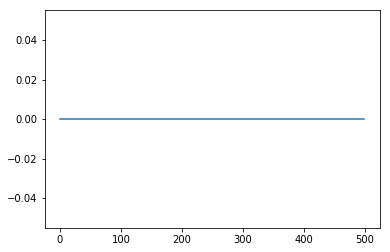

In [16]:
plt.plot(corr_sgn[49500:50000])

In [17]:
ord_max = int(25)
idx = np.argpartition(corr_sgn, -ord_max)[-ord_max:]
indices = idx[np.argsort((-corr_sgn)[idx])]
print(indices)

[2619975 5575842 2057828 1884905 4197090 2057998 3029567 1884851 1077572
 1184065 5847490 1077616 4196952 1884993 1184021 5585425 2058664    7167
 2058036 2058774 1884891 5575854 7531727 2619944 4197788]


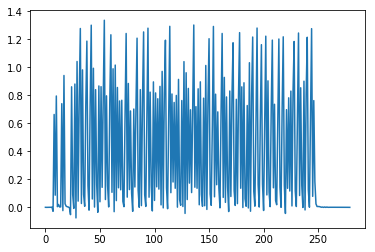

In [18]:
i = 2057820
plt.plot(zdeci[i:i+280])

In [19]:
print(i)
zdeci

2057820


array([0.00033133, 0.00024493, 0.00020991, ..., 0.00054992, 0.00061846,
       0.00083711])

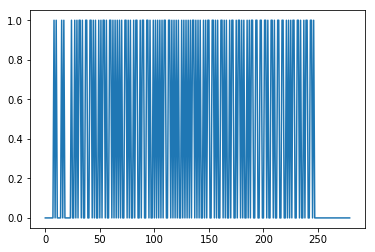

In [20]:
zdecision = np.zeros(280)
for idx in range(280):
    if zdeci[i+idx] > 0.4:
        zdecision[idx] = 1.
    else:
        zdecision[idx] = 0.
plt.plot(zdecision) 

In [21]:
print(zdecision)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### REG	MSN	AIRCRAFT TYPE	AIRLINE	DELIVERED	STATUS	PREV. REG	REMARK	
HL7772  3483  Airbus A320-200	 Asiana Airlines	May 2008	Active	F-WWDN	lsd

https://www.planespotters.net/search?q=71bf72